# Approximate Bayesian Computation (ABC)

***

Michael Burkhardt, Fabian Kessler, Dominik Straub

<img src="img/stochastic_simulator.png" style="max-width: 80%; width: 50%">

# Recap: Basic idea

> $p(\mathbf{\theta} \, | \, \mathbf x_{obs}) = \frac{p(\mathbf x_{obs} \, | \, \mathbf{\theta}) \: p(\mathbf{\theta})}{p(\mathbf x_{obs})}$



<font color="darkred"><strong>Problem</strong></font>: likelihood intractable or too expensive

* data-generating process can still be simulated
* bypass likelihood evaluation by simulating data
* accept parameter values for which simulated data are close to observed data

# Rejection ABC
<img src="img/concept1.png" style="max-width:100%; width: 50%"/>

<img src="img/concept2.png" style="max-width:100%; width: 50%"/>

<img src="img/concept3.png" style="max-width:100%; width: 50%"/>

<font color="darkred"><strong>Possible problems of Rejection ABC</strong></font>:
*** 
- choice of $\epsilon$ is crucial
- small $\epsilon$ lead to very high rejection rates $\Rightarrow$ acceptance rate of only 1% or less
- hugh problems when prior and likelihood are far apart
- only feasable if simulation process is very cheap
- what are good sufficient summary statistics
- curse of dimensionality

# Sequential Monte Carlo ABC
<img src="img/smcabc.png" style="max-width:100%; width: 70%"/>

<font color="darkred"><strong>Possible problems of SMC ABC</strong></font>:
***
- choice and number of $\epsilon$ is still crucial
- $\epsilon$ has to be choosen manually in a way that allows the algorithm to smoothly progress towards the region of high density

<img src="img/scope_without_ticks.png" style="max-width:100%; width: 80%"/>

<font align="left" color="darkblue" size="6" style="font-family: 'Helvetica'; line-height:1.2em;">Lets explore what we have done so far</font>

***

<font align="right" color="darkblue" size="5" style="font-family: 'Helvetica'; line-height: 1.1em;">And what you can do with our package</font>

# Toy example


In [19]:
import scipy.stats as ss
import pylab as plt
import numpy as np
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc
from pyabc.plots import plot_marginals

%matplotlib notebook

<IPython.core.display.Javascript object>


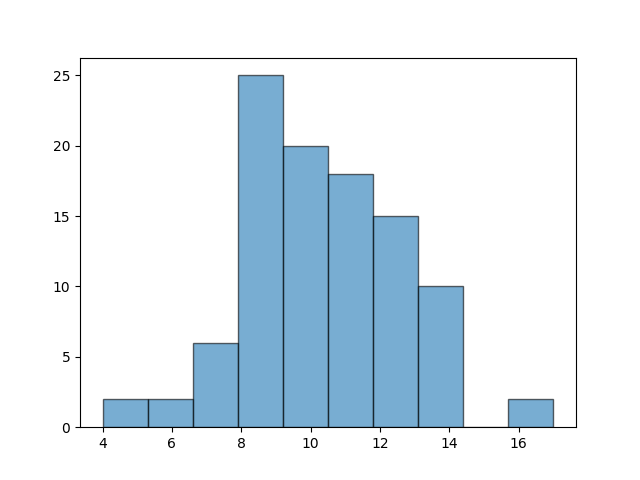

<IPython.core.display.Javascript object>


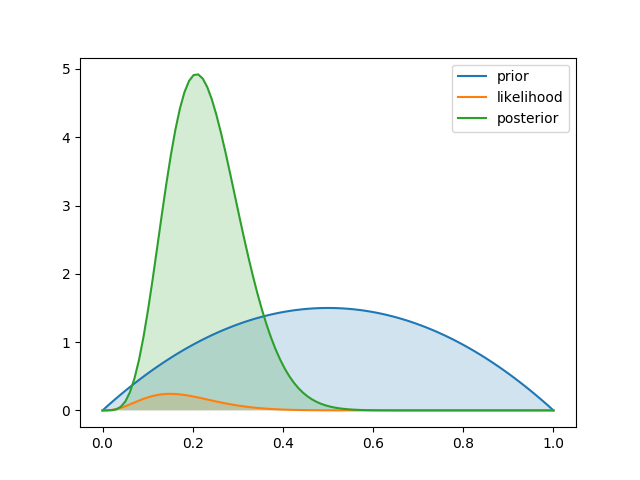

In [65]:
# create beta prior and likelihood and posterior
N = 20
prior = ss.beta(2,2)
likelihood = lambda p: ss.binom(N, p)
posterior = lambda x: ss.beta(a + x, b + N - x)

# create simulator
def simulator(p, size=1):
    global N
    return ss.binom(N, p).rvs(size)

plt.figure()
plt.hist(simulator(0.5, 100), alpha=0.6, edgecolor="k")
plt.show()

# observation
X = simulator(0.2)

# true posterior: beta(a + sum x, b + sum N - sum x)
a, b = 3,3

plt.figure()
x = np.linspace(0,1, 100)

y = prior.pdf(x)
plt.plot(x,y, label="prior")
plt.fill_between(x, y1=0, y2=y, alpha=0.2)

y = likelihood(x).pmf(X)
plt.plot(x,y, label="likelihood")
plt.fill_between(x, y1=0, y2=y, alpha=0.2)

y = posterior(X).pdf(x)
plt.plot(x,y, label="posterior")
plt.fill_between(x, y1=0, y2=y, alpha=0.2)

plt.legend()
plt.show()

Rejection sampler started with threshold: 0 and number of samples: 1000
Samples:   1000 - Threshold: 0.0000 - Iterations:      25000 - Acceptance rate: 0.040000 - Time:    14.36 s


<IPython.core.display.Javascript object>


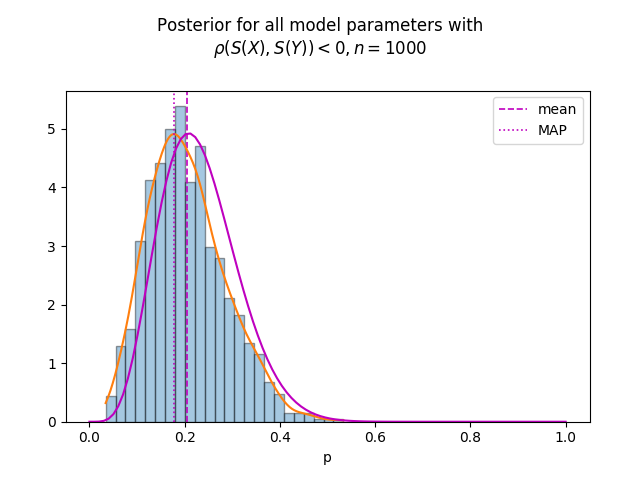

In [71]:
# now ABC
# create prior
prior = pyabc.Prior("beta", 2, 2, name="p")

# what can you do with it? sample, pdf

# create sampler
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator, summaries=lambda x: x, observation=X)

# sample
rej.sample(nr_samples=1000, threshold=0)

# plot marginals and posterior
plot_marginals(rej)
x = np.linspace(0,1, 100)
y = posterior(X).pdf(x)
plt.plot(x,y, "-m")

MCMC sampler started with threshold: 0 and number of samples: 3000
Samples:   3000 - Threshold: 0.0000 - Iterations:      28579 - Acceptance rate: 0.104972 - Time:    26.91 s


<IPython.core.display.Javascript object>


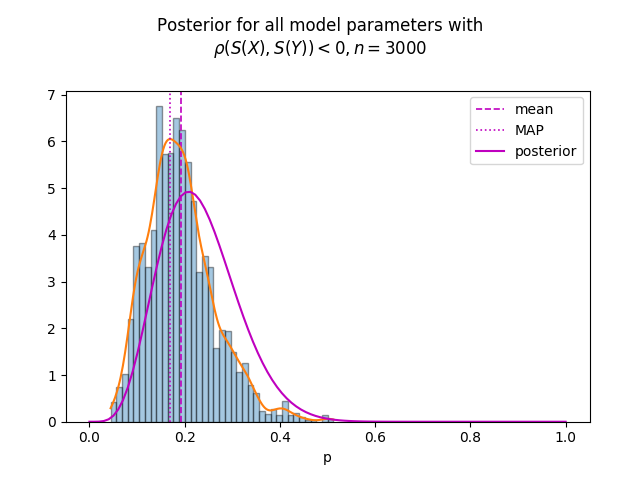

In [76]:
mcmc = pyabc.MCMCSampler(priors=prior, simulator=simulator, summaries=lambda x: x, observation=X)
mcmc.sample(nr_samples=3000, threshold=0, step_size=[0.1])
plot_marginals(mcmc)

x = np.linspace(0,1, 100)
y = posterior(X).pdf(x)
plt.plot(x,y, "-m", label="posterior")
plt.legend()

# Clinic example

In [ ]:
# some code

# Gaussian Mixture

In [ ]:
# some code

# BOLFI (Gutmann & Corander, 2016)

Why is ABC so expensive?
* It rejects lots of samples when $\epsilon$ is small
* It makes no assumptions about the form of the likelihood
* It does not use all information available
* It aims at equal accuracy for the whole parameter space

What can we do about this?
* Learn from rejected samples
* Model the distances, assume smoothness
* Use Bayes' Theorem to update the model
* Prioritize parameter regions that produce small distances

<img src="img/bolfi.png" style="max-width:100%; width: 90%"/>

# Outlook / report

In [2]:
# what comes next?